In [ ]:
#state space plot

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import RobustScaler, StandardScaler

import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import data_utils, spike_utils

# plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams.update({'font.size': 8,'pdf.fonttype':42})

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [ ]:
# load a session
# session_id='703880_2024-04-18' #bad behavior
session_id='715710_2024-07-17' #good behavior
# session_id='668759_2023-07-12' #templeton

session = DynamicRoutingSession(session_id)
session_info=npc_lims.get_session_info(session.id)
trials=data_utils.load_trials_or_units(session,'trials')
units=data_utils.load_trials_or_units(session,'units')

# print areas recorded
units['structure'].unique()


715710_2024-07-17 cached trials loaded
715710_2024-07-17 cached units loaded


array(['CA1', 'CA2', 'CA3', 'DG', 'FF', 'LD', 'LGd', 'MB', 'MGm', 'MGv',
       'MRN', 'PoT', 'RN', 'RSPagl', 'RSPv', 'RT', 'SCdg', 'SCig', 'SCiw',
       'SCop', 'SCsg', 'SCzo', 'SPFp', 'SSp', 'TH', 'VISp', 'VISrl',
       'VPL', 'fi', 'fp', 'or'], dtype=object)

In [ ]:
units=units.query('isi_violations_ratio<=0.5 and presence_ratio>=0.9 and amplitude_cutoff<=0.1')

In [32]:
# trials.query('is_target==True and is_rewarded==False')
# trials.columns
# trials.query('(is_vis_target and is_aud_context) or (is_aud_target and is_vis_context)')[['context_name','stim_name']].value_counts()

In [41]:
trials.index.values

array([  5,   9,  12,  21,  25,  31,  33,  35,  40,  44,  51,  58,  59,
        61,  74,  77,  79,  83,  97,  99, 104, 112, 115, 116, 120, 121,
       128, 130, 137, 142, 145, 156, 158, 162, 166, 168, 173, 183, 184,
       186, 195, 198, 200, 210, 215, 216, 219, 227, 228, 229, 231, 236,
       246, 248, 253, 255, 256, 265, 266, 273, 275, 279, 284, 287, 294,
       296, 300, 306, 310, 321, 325, 328, 329, 330, 339, 343, 347, 350,
       360, 369, 371, 374, 381, 392, 393, 395, 402, 403, 407, 408, 414,
       415, 420, 429, 435, 436, 440, 442, 445, 453, 458, 461, 467, 469,
       475, 476, 477, 478, 490, 495, 503, 507, 511, 514, 516, 517, 526,
       528, 531], dtype=int64)

In [37]:
# len(np.where(trials['is_vis_target'].values)[0])
# np.ones(len(np.where(trials['is_vis_target'].values)[0]))
np.mean(is_vis_appropriate_response)

0.5630252100840336

715710_2024-07-17 cached trials loaded


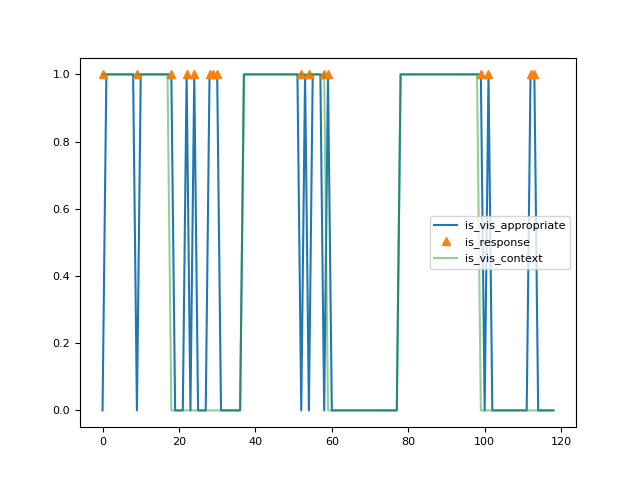

In [35]:
trials=data_utils.load_trials_or_units(session,'trials')
trials=trials.query('(is_vis_target and is_aud_context) or (is_aud_target and is_vis_context)')
is_vis_appropriate_response=(trials['is_vis_target'].values & trials['is_response'].values) | (trials['is_aud_target'].values & ~trials['is_response'].values)

fig,ax=plt.subplots(1,1)
ax.plot(is_vis_appropriate_response,label='is_vis_appropriate')
# ax.plot(np.where(trials['is_vis_target'].values)[0],
#         np.ones(len(np.where(trials['is_vis_target'].values)[0])),'o',label='is_vis_target')
ax.plot(np.where(trials['is_response'].values)[0],
        np.ones(len(np.where(trials['is_response'].values)[0])),'^',label='is_response')
ax.plot(trials['is_vis_context'].values,label='is_vis_context',alpha=0.5)
ax.legend()

In [39]:
#process spike info just like in decoding analysis

spikes_binsize=0.2 #bin size in seconds
spikes_time_before=0.2 #time before the stimulus per trial
spikes_time_after=0.01 #time after the stimulus per trial

#make trial data array for baseline activity
trial_da = spike_utils.make_neuron_time_trials_tensor(units, trials, spikes_time_before, spikes_time_after, spikes_binsize)

if 'Templeton' in session_info.project:
    start_time=trials['start_time'].iloc[0]
    fake_context=np.full(len(trials), fill_value='nan')
    fake_block_nums=np.full(len(trials), fill_value=np.nan)
    block_context_names=['vis','aud']

    if np.random.choice(block_context_names,1)=='vis':
        block_contexts=['vis','aud','vis','aud','vis','aud']
    else:
        block_contexts=['aud','vis','aud','vis','aud','vis']

    for block in range(0,6):
        block_start_time=start_time+block*10*60
        block_end_time=start_time+(block+1)*10*60
        block_trials=trials[:].query('start_time>=@block_start_time').index
        fake_context[block_trials]=block_contexts[block]
        fake_block_nums[block_trials]=block
    trials['block_index']=fake_block_nums
    trials['context_name']=fake_context
    
labels=trials['context_name'].values
input_data=trial_da.mean(dim='time').T



In [12]:
input_data.values.shape

(513, 3445)

explained variance ratio (first two components): [0.04643052 0.03470616]


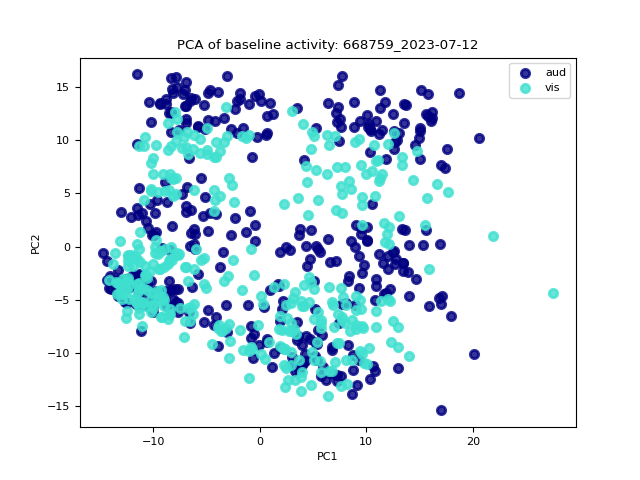

In [40]:
# X = input_data
y = labels=='aud'
target_names = ['aud','vis']

# scaler = RobustScaler()
scaler = StandardScaler()

scaler.fit(input_data)
X = scaler.transform(input_data)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# lda = LinearDiscriminantAnalysis(n_components=1)
# X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of baseline activity: "+session_id)

# plt.figure()
# for color, i, target_name in zip(colors, [0, 1, 2], target_names):
#     plt.scatter(
#         X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
#     )
# plt.legend(loc="best", shadow=False, scatterpoints=1)
# plt.title("LDA of IRIS dataset")

plt.show()

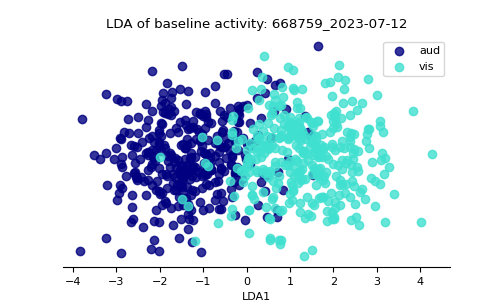

In [41]:
# X = input_data
y = labels=='aud'
target_names = ['aud','vis']

# scaler = RobustScaler()
scaler = StandardScaler()

scaler.fit(input_data)
X = scaler.transform(input_data)

lda = LinearDiscriminantAnalysis(n_components=1)
X_r2 = lda.fit(X, y).transform(X)

colors = ["navy", "turquoise", "darkorange"]

#make y coord jittered
ycoords=np.ones(len(X_r2[:,0]))
y_jittered = ycoords + np.random.normal(0,0.1,len(y))

fig,ax=plt.subplots(figsize=(5,3))
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(
        X_r2[y == i, 0], y_jittered[y==i], alpha=0.8, color=color, label=target_name
    )
ax.legend(loc="best", shadow=False, scatterpoints=1)
ax.set_title("LDA of baseline activity: "+session_id)
ax.set_xlabel("LDA1")
ax.set_ylabel("")
ax.set_yticklabels([])
ax.set_yticks([])

#remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)



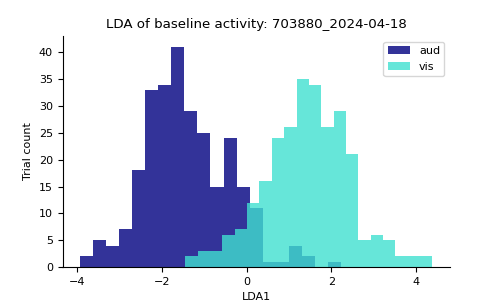

In [23]:
fig,ax=plt.subplots(figsize=(5,3))

xbins=np.linspace(-5,5,100)
#plot histogram of LDA outputs
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.hist(
        X_r2[y == i, 0], alpha=0.8, color=color, label=target_name, bins=20
    )

ax.legend(loc="best", shadow=False, scatterpoints=1)
ax.set_title("LDA of baseline activity: "+session_id)
ax.set_xlabel("LDA1")
ax.set_ylabel("Trial count")

#remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [31]:
units['structure'].unique()

array(['ACAd', 'ACAv', 'ACB', 'CA3', 'CP', 'DG', 'LSr', 'MOs', 'OT',
       'PAG', 'ProS', 'RSPd', 'RSPv', 'RT', 'SCdg', 'SCdw', 'SCig',
       'SCiw', 'SCop', 'SCsg', 'SF', 'SI', 'SSp', 'SUB', 'VAL', 'VISpor',
       'VL', 'VM', 'VPL', 'VPM', 'fa', 'or'], dtype=object)

In [ ]:
#LDA for a single area

areas='MRN'

area_units=units.query('structure==@area')

#make trial data array for baseline activity
area_trial_da = spike_utils.make_neuron_time_trials_tensor(area_units, trials, spikes_time_before, spikes_time_after, spikes_binsize)

labels=trials['context_name'].values
area_input_data=area_trial_da.mean(dim='time').T


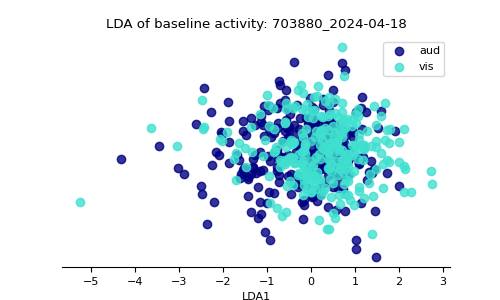

In [26]:
# X = input_data
y = labels=='aud'
target_names = ['aud','vis']

# scaler = RobustScaler()
scaler = StandardScaler()

scaler.fit(area_input_data)
X = scaler.transform(area_input_data)

lda = LinearDiscriminantAnalysis(n_components=1)
X_r2 = lda.fit(X, y).transform(X)

colors = ["navy", "turquoise", "darkorange"]

#make y coord jittered
ycoords=np.ones(len(X_r2[:,0]))
y_jittered = ycoords + np.random.normal(0,0.1,len(y))

fig,ax=plt.subplots(figsize=(5,3))
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(
        X_r2[y == i, 0], y_jittered[y==i], alpha=0.8, color=color, label=target_name
    )
ax.legend(loc="best", shadow=False, scatterpoints=1)
ax.set_title("LDA of baseline activity: "+session_id)
ax.set_xlabel("LDA1")
ax.set_ylabel("")
ax.set_yticklabels([])
ax.set_yticks([])

#remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)



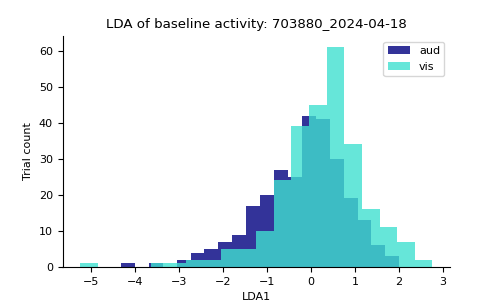

In [27]:
fig,ax=plt.subplots(figsize=(5,3))

xbins=np.linspace(-5,5,100)
#plot histogram of LDA outputs
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.hist(
        X_r2[y == i, 0], alpha=0.8, color=color, label=target_name, bins=20
    )

ax.legend(loc="best", shadow=False, scatterpoints=1)
ax.set_title("LDA of baseline activity: "+session_id)
ax.set_xlabel("LDA1")
ax.set_ylabel("Trial count")

#remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [44]:
len(units.query('structure=="VISp"'))

103

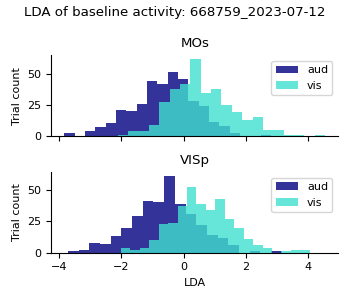

In [ ]:
#plot LDA for 2 example areas:
areas=['MOs','VISp']

fig,ax=plt.subplots(2,1,figsize=(3.5,3),sharex=True,)

for aa,area in enumerate(areas):

    area_units=units.query('structure==@area')

    #make trial data array for baseline activity
    area_trial_da = spike_utils.make_neuron_time_trials_tensor(area_units, trials, spikes_time_before, spikes_time_after, spikes_binsize)

    labels=trials['context_name'].values
    area_input_data=area_trial_da.mean(dim='time').T

    # X = input_data
    y = labels=='aud'
    target_names = ['aud','vis']

    # scaler = RobustScaler()
    scaler = StandardScaler()

    scaler.fit(area_input_data)
    X = scaler.transform(area_input_data)

    lda = LinearDiscriminantAnalysis(n_components=1)
    X_r2 = lda.fit(X, y).transform(X)

    colors = ["navy", "turquoise", "darkorange"]

    #make y coord jittered
    ycoords=np.ones(len(X_r2[:,0]))
    y_jittered = ycoords + np.random.normal(0,0.1,len(y))

    
    xbins=np.linspace(-5,5,100)
    #plot histogram of LDA outputs
    for color, i, target_name in zip(colors, [0, 1], target_names):
        ax[aa].hist(
            X_r2[y == i, 0], alpha=0.8, color=color, label=target_name, bins=20
        )

    ax[aa].legend(loc="best", shadow=False, scatterpoints=1)
    ax[aa].set_title(area)
    ax[aa].set_ylabel("Trial count")

    #remove top and right spines
    ax[aa].spines['top'].set_visible(False)
    ax[aa].spines['right'].set_visible(False)

ax[aa].set_xlabel("LDA")

fig.suptitle("LDA of baseline activity: "+session_id)
fig.tight_layout()


In [17]:
#save figure
temp_loadpath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-11-25-updated-plots_for_paper"
savepath=os.path.join(temp_loadpath,'LDA_baseline_activity_'+session_id)
fig.savefig(savepath+'.pdf',format='pdf',bbox_inches='tight',dpi=600)
fig.savefig(savepath+'.png',format='png',bbox_inches='tight', pad_inches=0,
            metadata=None, dpi=600)